# Tests of coordinate system effects on shear profiles

Author:  Tomomi Sunayama, July 15, 2024

Tested, modified, and documented by: Camille Avestruz, July 18, 2024


This notebook illustrates the impact of having an incorrect coordinate system when calculating shear profiles.  The default coordinate system for `CLMM` is the pixel coordinate system.  This is consistent with DC2 catalogs.  However, if we input a catalog that assumes a sky coordinate system and use the default pixel coordinate system (or vice versa), the signal of shear around a cluster disappears because the signal essentially looks random.

We test:
- CosmoDC2 source galaxies with shears extracted from `TXPipe` for a single galaxy cluster (pixel coordinate system)
- Example source galaxies for galaxy clusters from a [Summer School](https://github.com/oguri/wlcluster_tutorial) taught by Masamune Oguri (pixel coordinate system)
- HSC Y3 source galaxies with shears post processed by Tomomi Sunayama (sky coordinate system)

We also 
- Compare the explicit calculation of a shear profile on the HSC Y3 source galaxies against a profile produced from `CLMM`. 


## Instructions to download text data

Before running this notebook, you will need to download some data.  The data is available through a [dropbox link](https://www.dropbox.com/scl/fo/dwsccslr5iwb7lnkf8jvx/AJkjgFeemUEHpHaZaHHqpAg?rlkey=efbtsr15mdrs3y6xsm7l48o0r&st=xb58ap0g&dl=0)

First, create a directory where you want to put the example data, e.g. for a given `data_coords_dir`:
```
data_coords_dir="<YOUR PATH TO DATA COORDS DIR>/data_coords"
mkdir -p $data_coords_dir
cd $data_coords_dir
```
Download all files from [dropbox link](https://www.dropbox.com/scl/fo/dwsccslr5iwb7lnkf8jvx/AJkjgFeemUEHpHaZaHHqpAg?rlkey=efbtsr15mdrs3y6xsm7l48o0r&st=xb58ap0g&dl=0).  This will be a zip file, `CLMM_data.zip` of size 242 Mb. scp or move this to `$data_coords_dir`.

From the directory, you should be able to unzip:
```
unzip data_CLMM.zip -d .
```
You now have the necessary data files to run this notebook.  

**Make sure to change the `data_coords_dir` variable in the cell below to the appropriate location where you unzipped these files.**


In [1]:
#  CHANGE THIS TO YOUR LOCATION
data_coords_dir="/pscratch/sd/a/avestruz/clmm-area/CLMM_test_data/data_coords/"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib inline
from astropy.table import Table
import pickle as pkl
from pathlib import Path
import pandas
from astropy.io import fits

In [3]:
from clmm import Cosmology
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

## Example galaxy cluster from CosmoDC2

Here, we plot an example galaxy cluster shear profile using `clmm`.  The cluster and source galaxy files are generated from the CosmoDC2 processed through TXPipe.  We test the coordinate system.

In [4]:
cluster = pandas.read_pickle(data_coords_dir+'test_cluster.pkl')

In [5]:
cluster_z = cluster['redshift']  # Cluster redshift
cluster_ra = cluster['ra']  # Cluster Ra in deg
cluster_dec = cluster['dec']

In [6]:
source = np.genfromtxt(data_coords_dir+'test_source.txt',names=True)

In [7]:
gal_ra = source['ra']
gal_dec = source['dec']
gal_e1 = source['e1']
gal_e2 = source['e2']
gal_z = source['zmean']
gal_id = np.arange(len(source['ra']))

In [8]:
import clmm
import clmm.dataops as da
from clmm.utils import convert_units

# Create a GCData with the galaxies.
galaxies = clmm.GCData(
    [gal_ra, gal_dec, gal_e1, gal_e2, gal_z, gal_id], names=["ra", "dec", "e1", "e2", "z", "id"]
)

Here we create a `GalaxyCluster` object, specifying an *incorrect* coordinate system.  For source galaxies from CosmoDC2, these are in the **pixel** coordinate system.  We use the implemented kwarg when defining the galaxy cluster object to specify the **sky** coordinate system.

In [9]:
# Create a GalaxyCluster.
cluster = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec, cluster_z, galaxies, coordinate_system="sky")

# Convert elipticities into shears for the members.
cluster.compute_tangential_and_cross_components()
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster.galcat["theta"], "radians", "Mpc", cluster.z, cosmo)

cluster.make_radial_profile(
    bins=da.make_bins(0.1, 3.0, 15, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=True,
)
print(cluster.profile.colnames)

['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'W_l', 'gal_id']


Here, we plot the resulting profile when `clmm` uses assumes a coordinate system inconsistent with the catalogs provided.  You will note that the signal is virtually zero at almost all radii.

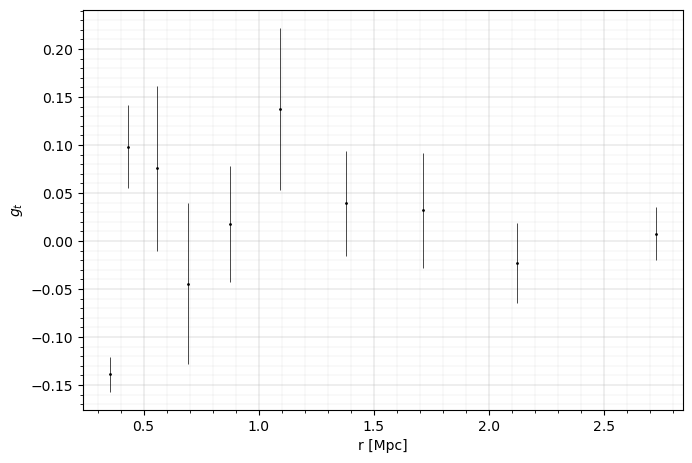

In [10]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle="", marker="o", markersize=1, elinewidth=0.5, capthick=0.5)
ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["gt"],
    cluster.profile["gt_err"],
    c="k",
    **errorbar_kwargs
)
ax.set_xlabel("r [Mpc]", fontsize=10)
ax.set_ylabel(r"$g_t$", fontsize=10)
ax.grid(lw=0.3)
ax.minorticks_on()
ax.grid(which="minor", lw=0.1)
plt.show()

Here we create a `GalaxyCluster` object, specifying the *correct* coordinate system.  For source galaxies from CosmoDC2, these are in the **pixel** coordinate system.  We use the implemented kwarg when defining the galaxy cluster object to also specify the **pixel** coordinate system.  However, with a single galaxy cluster, the signal is not significant enough to clearly see a difference.  We do notice an excess with the correct coordinate system at larger radii.

['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'W_l', 'gal_id']


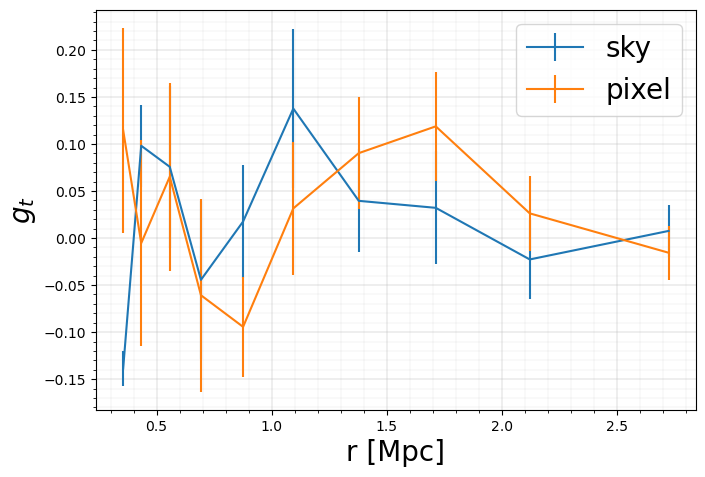

In [11]:
cluster2 = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec, cluster_z, galaxies, coordinate_system="pixel")
cluster2.compute_tangential_and_cross_components()
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster2.galcat["theta"], "radians", "Mpc", cluster2.z, cosmo)

cluster2.make_radial_profile(
    bins=da.make_bins(0.1, 3.0, 15, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=True,
)
print(cluster.profile.colnames)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle="", marker="o", markersize=1, elinewidth=0.5, capthick=0.5)
ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["gt"],
    cluster.profile["gt_err"],
    label='sky'   
)
ax.errorbar(
    cluster2.profile["radius"],
    cluster2.profile["gt"],
    cluster2.profile["gt_err"],
    label='pixel'
)
ax.set_xlabel("r [Mpc]", fontsize=20)
ax.set_ylabel(r"$g_t$", fontsize=20)
ax.grid(lw=0.3)
ax.minorticks_on()
ax.grid(which="minor", lw=0.1)
plt.legend(fontsize=20)
plt.show()

## Example source galaxies from M. Oguri

This dataset is a curated selection of cluster and source catalogs from Summer School lectures delivered by Masamune Oguri.  There are eight galaxy clusters in this selection.  

More details on the corresponding tutorial can be found at this [GitHub link](https://github.com/oguri/wlcluster_tutorial). The coordinate system is pixel.  These are also in the **pixel** coordinate system.

In [12]:
clusters = ['a1703', 'gho1320', 'sdss0851', 'sdss1050', 
            'sdss1138', 'sdss1226', 'sdss1329', 'sdss1531']

zl_all = {'a1703': 0.277, 'gho1320': 0.308, 'sdss0851': 0.370, 'sdss1050': 0.60, 
          'sdss1138': 0.451, 'sdss1226': 0.435, 'sdss1329': 0.443, 'sdss1531': 0.335}

ra_cl_all = {'a1703': 198.771833, 'gho1320': 200.703208, 'sdss0851': 132.911917, 'sdss1050': 162.666250, 
             'sdss1138': 174.537292, 'sdss1226': 186.712958, 'sdss1329': 202.393708, 'sdss1531':  232.794167}

dec_cl_all = {'a1703': 51.817389, 'gho1320': 31.654944, 'sdss0851': 33.518361, 'sdss1050': 0.285306, 
              'sdss1138': 27.908528, 'sdss1226': 21.831194, 'sdss1329': 22.721167, 'sdss1531':  34.240278}

In [13]:
cname   = 'a1703'

# cluster redshift
zl      = zl_all.get(cname)

# coordinates of the cluster center
ra_cl   = ra_cl_all.get(cname)
dec_cl  = dec_cl_all.get(cname)

# fix source redshift to 1.0
zs = 1.0

We inspect the first galaxy cluster, Abell 1703.

In [14]:
rfile = data_coords_dir+'data/shear_' + cname + '.dat'
data = np.loadtxt(rfile, comments = '#')

ra  = data[:, 0]
dec = data[:, 1]
e1  = data[:, 2]
e2  = data[:, 3]
wei = data[:, 4]
ids = np.arange(np.shape(data)[0])
redshifts=np.ones(np.shape(data)[0])
galaxies = clmm.GCData(
    [ra, dec, e1, e2, redshifts, ids], names=["ra", "dec", "e1", "e2", "z", "id"]
)

Here we create a GalaxyCluster object, specifying the correct coordinate system. For source galaxies from the Oguri curated dataset, these are in the pixel coordinate system. We use the implemented kwarg when defining the galaxy cluster object to also **specify the pixel coordinate system**.

['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'W_l', 'gal_id']
['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'W_l', 'gal_id']


/pscratch/sd/a/avestruz/clmm-area/lib/python3.11/site-packages/clmm/utils/statistic.py:97: RuntimeWarning: invalid value encountered in sqrt
  err_y = np.sqrt(stat_yerr2 + data_yerr2)
/pscratch/sd/a/avestruz/clmm-area/lib/python3.11/site-packages/clmm/utils/statistic.py:97: RuntimeWarning: invalid value encountered in sqrt
  err_y = np.sqrt(stat_yerr2 + data_yerr2)
/pscratch/sd/a/avestruz/clmm-area/lib/python3.11/site-packages/clmm/galaxycluster.py:632: UserWarning: overwriting profile table.
  warnings.warn(f"overwriting {table_name} table.")


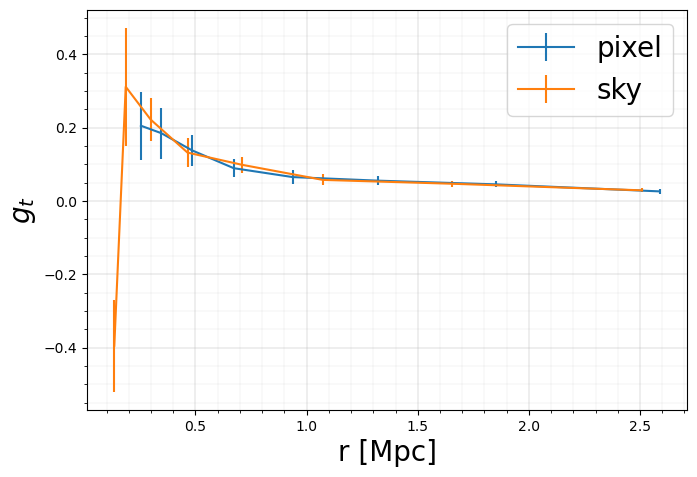

In [15]:
cluster = clmm.GalaxyCluster("Name of cluster", ra_cl, dec_cl, zl, galaxies, coordinate_system="pixel")

# Convert elipticities into shears for the members.
cluster.compute_tangential_and_cross_components()
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster.galcat["theta"], "radians", "Mpc", cluster.z, cosmo)

cluster.make_radial_profile(
    bins=da.make_bins(0.2, 3.0, 8, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=True,
)
print(cluster.profile.colnames)


fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle="", marker="o", markersize=1, elinewidth=0.5, capthick=0.5)
ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["gt"],
    cluster.profile["gt_err"],
    label='pixel'
)


cluster.compute_tangential_and_cross_components()
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster.galcat["theta"], "radians", "Mpc", cluster.z, cosmo)

cluster.make_radial_profile(
    bins=da.make_bins(0.1, 3.0, 8, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=True,
)
print(cluster.profile.colnames)

ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["gt"],
    cluster.profile["gt_err"],
    label='sky'
)


ax.set_xlabel("r [Mpc]", fontsize=20)
ax.set_ylabel(r"$g_t$", fontsize=20)
ax.grid(lw=0.3)
ax.minorticks_on()
ax.grid(which="minor", lw=0.1)
plt.legend(fontsize=20)
plt.show()

## Example source galaxies from HSC Y3

This dataset is a simplified version of HSC Y3 data (GAMA15H), post-processed by Tomomi Sunayama for testing purposes.  The pre-processed data is already public. These catalogs assume a **sky** pixel coordinate system.

In [16]:
cluster_cat = np.genfromtxt(data_coords_dir+'GAMA15H/redmapper_dr8_GAMA15H.txt',dtype=np.dtype([('ra',np.float64),('dec',np.float64),('z',np.float64),('richness',np.float64)]))

In [17]:
source_cat = fits.getdata(data_coords_dir+'GAMA15H/GAMA15H_tutorial.fits')

In [18]:
cl = cluster_cat[0]

Here, we use a KDTree implementation in scipy to extract the background source galaxies for the first galaxy cluster in the dataset.

In [19]:
from scipy import spatial
source1 = source_cat[source_cat['photoz']>(cl['z']+0.3)]
tree = spatial.cKDTree(np.array((source1['ra'],source1['dec'])).T)
sel = tree.query_ball_point([cl['ra'],cl['dec']], 3)
bg = source1[sel]

In [20]:
# Inspect background source galaxy selection
bg

FITS_rec([(210.82153548, -1.50709995, 1.3758055 ,  0.08092293,  0.10835767, 3.90404153, 0.40599512, -0.25950627,  0.00161883,  0.00240663, 0.51526076),
          (210.82056121, -1.50160523, 1.88367689,  0.32586864, -0.48157749, 4.3604162 , 0.40619245, -0.23469312,  0.00020266,  0.00030905, 0.53453451),
          (210.82007918, -1.50101615, 1.50016546, -0.79242778,  0.51766521, 5.15488992, 0.42237528, -0.2440048 , -0.00142779, -0.0021891 , 0.78542656),
          ...,
          (216.26079337,  1.00315502, 0.96254927,  0.31060243,  0.3478314 , 6.60712636, 0.38664818, -0.092641  , -0.00031831,  0.00021643, 0.62135643),
          (216.25910859,  1.00395592, 1.1813668 , -0.26740584,  0.51656026, 4.80835742, 0.44251237, -0.21937594, -0.00162366,  0.00109805, 0.87557292),
          (216.25940093,  1.0079921 , 0.99761593, -0.2840299 ,  0.08879771, 7.09330649, 0.37434303, -0.07929059, -0.00029026,  0.00019429, 0.65537405)],
         dtype=(numpy.record, [('RA', '>f8'), ('Dec', '>f8'), ('photoz',

In [21]:
sources = clmm.GCData(
    [bg['RA'], bg['Dec'], bg['e1'], bg['e2'], bg['photoz'],bg['weight']], names=["ra", "dec", "e1", "e2", "z", "w_ls"]
)

In [22]:
cluster = clmm.GalaxyCluster("redmapper", cl['ra'], cl['dec'], cl['z'], sources, coordinate_system="sky")

In [23]:
sigma_c = cosmo.eval_sigma_crit(cl['z'], sources['z'])

In [24]:
cluster.compute_tangential_and_cross_components(
        shape_component1="e1",
        shape_component2="e2",
        tan_component="DS_t",
        cross_component="DS_x",
        cosmo=cosmo,
        is_deltasigma=True,
        use_pdz=False,
    )

(array([0.052344  , 0.05232376, 0.05232771, ..., 0.05231502, 0.05229537,
        0.0523324 ]),
 array([-5.10269837e+14,  3.74729642e+14,  7.93988192e+14, ...,
        -1.85411312e+15, -1.04588999e+15,  3.57887320e+14]),
 array([-8.04914013e+13,  2.12751947e+15, -3.49523009e+15, ...,
         2.15420568e+14, -2.00476291e+15, -1.12910097e+15]))

In [25]:
cluster

ra,dec,e1,e2,z,w_ls,sigma_c,theta,DS_t,DS_x
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
210.8215354813783,-1.50709995286189,0.080922931432724,0.10835766792297363,1.3758054971694946,3.9040415282504566,3819717759154588.0,0.052343996166526664,-510269837472835.9,-80491401304217.47
210.82056121413385,-1.501605229871928,0.3258686363697052,-0.48157748579978943,1.8836768865585327,4.36041620180457,3715185997774635.5,0.05232375893970237,374729641659883.75,2127519469704164.8
210.8200791752013,-1.5010161459837505,-0.7924277782440186,0.5176652073860168,1.5001654624938965,5.154889916819879,3786756084614114.0,0.052327708719497004,793988192157035.8,-3495230088192310.0
210.82082842507086,-1.499351539271592,-0.21478858590126038,-0.2778179943561554,0.8998898267745972,5.397681641813118,4048244596644628.0,0.052304718040591086,1406736556172689.5,205050975125410.06
210.81366421204987,-1.486697530468446,-0.11857343465089798,-0.4502687156200409,1.4502933025360107,4.673579759394774,3799208116450610.5,0.05233868788690602,1503454867834197.0,932166062918862.9
210.82153080389844,-1.4913227048019966,-0.22311601042747498,-0.19615456461906433,1.3474977016448975,4.473369235863828,3828189601580814.0,0.05224111418412021,1136284397081030.2,-47672123899465.78
210.8268651999897,-1.50117481198046,0.31468430161476135,0.7756112813949585,1.4231806993484497,5.364098266327603,3806392172028079.5,0.05221897235809234,-2915819118185433.5,-1284022397943112.5
210.82653363712814,-1.5041122174230175,0.1492079198360443,-0.11162422597408295,1.3673487901687622,5.125241499962847,3822206869311561.5,0.05224358391760916,-110809337117976.55,703561220063007.0
210.8273420760493,-1.5073555744369433,-0.4043038785457611,0.27580970525741577,1.957611322402954,5.44979527242271,3704916575749617.5,0.052251822869295805,356019406953978.25,-1777968607710684.0


Now we construct a radial profile of the tangential and cross terms for the galaxy cluster

In [26]:
seps = convert_units(cluster.galcat["theta"], "radians", "Mpc", cluster.z, cosmo)

cluster.make_radial_profile(
    tan_component_in="DS_t",
    cross_component_in="DS_x",
    tan_component_out="DS_t",
    cross_component_out="DS_x",
    weights_in="w_ls",
    bins=da.make_bins(0.1, 20.0, 15, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=False,
)
print(cluster.profile.colnames)



['radius_min', 'radius', 'radius_max', 'DS_t', 'DS_t_err', 'DS_x', 'DS_x_err', 'z', 'z_err', 'n_src', 'W_l']


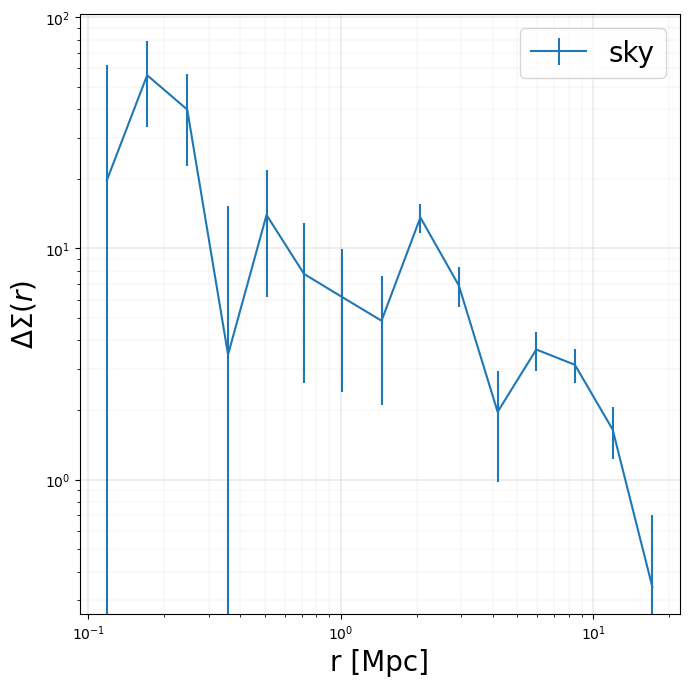

<Figure size 640x480 with 0 Axes>

In [27]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle="", marker="o", markersize=1, elinewidth=0.5, capthick=0.5)
ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["DS_t"]/ 1e13,
    cluster.profile["DS_t_err"]/1e13,
    label='sky'
)
plt.loglog()

ax.set_xlabel("r [Mpc]", fontsize=20)
ax.set_ylabel(r"$\Delta\Sigma(r)$", fontsize=20)
ax.grid(lw=0.3)
ax.minorticks_on()
ax.grid(which="minor", lw=0.1)
plt.legend(fontsize=20)
plt.show()
plt.savefig('clmm_hsc_cluster.png')


## Example explicit lensing profile measurement comparison with CLMM profile

Here, we use the example HSC Y3 dataset to explicitly measure the lensing signal without using CLMM for comparison.  Note, we need to still define a cosmology to calculate comoving distances.

In [28]:
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import spatial
from astropy.cosmology import WMAP5

In [29]:
# Read in the data
cluster_cat = np.genfromtxt(data_coords_dir+'GAMA15H/redmapper_dr8_GAMA15H.txt',dtype=np.dtype([('RA',np.float64),('Dec',np.float64),('z',np.float64),('richness',np.float64)]))
source_cat = fits.getdata(data_coords_dir+'GAMA15H/GAMA15H_tutorial.fits')

In [30]:
cosmo = WMAP5

Below, we measure lensing signals with simplified assumptions.  We do not account for responsivity, multiplicative, nor additive biases.  

In [31]:
# Define functions for the explicit calculation

def calcDistanceAngle(a1, d1, a2, d2) :
    '''Compute the angle between lens and source galaxies from ra, dec in radians'''
    return np.arccos(np.cos(d1)*np.cos(d2)*np.cos(a1-a2)+np.sin(d1)*np.sin(d2))

def cosPhi2(a1, a2, d1, d2, distanceAngle) :
    '''Compute $\cos(2\phi)$ for a given distance angle between lens and source galaxies from ra, dec in radians'''
    return np.sin(a2 - a1)*np.cos(d1)/np.sin(distanceAngle)

def sinPhi2(a1, a2, d1, d2, distanceAngle) :
    '''Compute $\sin(2\phi)$ for a given distance angle between lens and source galaxies from ra, dec in radians'''
    return (-np.cos(d2)*np.sin(d1) + np.sin(d2)*np.cos(d1)*np.cos(a1-a2))/np.sin(distanceAngle)

def compute_sin2phi_cos2phi(a1, a2, d1, d2, distanceAngle) :
    '''Compute necessary coefficients for the et and ex components, sin2phi and cos2phi'''
    cosp = cosPhi2(a1, a2, d1, d2, distanceAngle)
    sinp = sinPhi2(a1, a2, d1, d2, distanceAngle)
    cos2p = cosp**2 - sinp**2
    sin2p = 2.*sinp*cosp
    return cos2p, sin2p

def calc_et_ex(e1, e2, cos2p, sin2p) :
    ''' Calculate the et and ex from the e1 e2 values of all sources and their sin2phi, cos2phi
    '''
    et = -(e1*cos2p+e2*sin2p)
    ex = -(-e1*sin2p+e2*cos2p)
    return et, ex
       
def populate_profile_sums( ps, i_r, src_in_bin, Sigma_cr, sel, et, ex ) :
    '''Populate the profile sums at a given radian bin from the calculated selection, sigma_crit, et, and ex''' 
    ps["n"][i_r] += sel.sum()    
    ps["e_sq"][i_r] += np.sum(et**2 + ex**2)
    
    wt = src_in_bin["weight"]*Sigma_cr**-2 # multiply by the lens weights if it is not one
    ps["w"][i_r] += np.sum(wt)
    
    wetsigma = wt*Sigma_cr*et
    ps["wetsigma"][i_r] += np.sum(wetsigma)
    ps["wetsigma_sq"][i_r] += np.sum(wetsigma**2)
    
    wexsigma = wt*Sigma_cr*ex
    ps["wexsigma"][i_r] += np.sum(wexsigma)
    ps["wexsigma_sq"][i_r] += np.sum(wexsigma**2)
    
    wsigmainv = wt*1./Sigma_cr
    ps["wsigmainv"][i_r] += np.sum(wsigmainv)
    
    wzs = wt*src_in_bin["photoz"]
    ps["wzs"][i_r] += np.sum(wzs)

In [32]:
# Relevant constants, radial binning, source photoz range and lens photoz range

d2r = np.pi/180.
r2d = 180./np.pi
Mpc = 3.08568025*10**19 # 1Mpc = 3.08568025*10**19 km                                                                                                    
M_sun = 1.9884*10**33 # solar mass [g]  
c_light = 2.99792458*10**5 # speed of light [km/s] 
G = 6.67384*10**(-20) # gravitational constant [km^3s^-2kg^-1] 
Sigma_cr_fact = c_light**2/(4*np.pi*G)*Mpc*10**3/M_sun
rbin_edges = np.logspace(-1,np.log10(20),15) #Define your radial bins

# Named numpy arrays for relevant profile values to explicitly compute and sum at each radii
profile_names = ["e_sq", "w", "wetsigma", "wetsigma_sq", "wexsigma", "wexsigma_sq", "wsigmainv", "wzs", "n"]
profile_sums = np.rec.fromarrays([np.zeros(len(rbin_edges)-1) for i in profile_names], names = profile_names)

source_pz = {'min':0.5, 'max':10}
#source_pz = {'min':0.9, 'max':1.0}
lens_pz = {'min':0.1, 'max':0.2}

In [33]:
# Select lens clusters and source galaxies from catalogs using kdtree

source_pz_criteria = (source_cat['photoz']<source_pz['max'])&(source_cat['photoz']>source_pz['min'])
selected_sources = source_cat[source_pz_criteria]

tree = spatial.cKDTree(np.array((selected_sources['RA'],selected_sources['Dec'])).T)

# We only select one,selecting many will take much more time to compute. 
lens_pz_criteria = (cluster_cat['z']>lens_pz['min'])&(cluster_cat['z']<lens_pz['max'])
lens_clusters = cluster_cat[lens_pz_criteria][:1]  

# Set weights for the cluster lenses to one
lens_weights = np.ones(lens_clusters.size) 

In [34]:
# Calculate tangential shear for each lens

for ilens in np.arange(lens_clusters.size):

    #Select source galaxies
    sel = tree.query_ball_point([lens_clusters['RA'][ilens],lens_clusters['Dec'][ilens]], 3)
    sel_z = source_cat[sel]['photoz']>lens_clusters['z'][ilens] #Try to change the source galaxy selection
    source_bg = source_cat[sel][sel_z]
    
    # Compute an angle between the lens and the source
    theta_ls = calcDistanceAngle(lens_clusters['RA'][ilens]*d2r, lens_clusters['Dec'][ilens]*d2r, 
                              source_bg['RA']*d2r, source_bg['Dec']*d2r)  
    
    # Compute the comoving distance of the lens
    l_chi =  cosmo.comoving_distance((lens_clusters['z'][ilens])).value   
    r = theta_ls*l_chi                                                                                                 
    assign_r = np.digitize(r, rbin_edges)


    for i_r in range(len(rbin_edges)-1):
        #print i_r                                                                                                                               
        sel = assign_r == i_r+1
        source_bg_inbin = source_bg[sel]
        theta_sub = theta_ls[sel]
        
        # Compute the cos(2*phi) and sin(2*phi) for a given distance angle between lens and source galaxies
        cos2p, sin2p = compute_sin2phi_cos2phi(lens_clusters["RA"][ilens]*d2r, source_bg_inbin["RA"]*d2r, 
                                               lens_clusters["Dec"][ilens]*d2r, 
                                               source_bg_inbin["Dec"]*d2r, theta_sub)
        
        # Calculate tangential and cross terms from e1, e2 of all source galaxies in the rbin
        et, ex = calc_et_ex(source_bg_inbin["e1"], source_bg_inbin["e2"], cos2p, sin2p) 
        
        # Calculate critical surface mass density [M_sun/ comoving Mpc^2]. (1+zl)**-2 is for comoving coordinates.  
        comoving_distance = cosmo.comoving_distance((source_bg_inbin["photoz"])).value

        Sigma_cr = Sigma_cr_fact/(1. - l_chi/comoving_distance)/l_chi/(1.+lens_clusters["z"][ilens])/10**12  
        
        # Populate the profile_sums at this radial bin
        populate_profile_sums(profile_sums, i_r, source_bg_inbin, Sigma_cr, sel, et, ex )

In [35]:
# Compute the lensing signal            
radial_bin = 2.*(rbin_edges[1:]**3 - rbin_edges[:-1]**3)/(3.*(rbin_edges[1:]**2 - rbin_edges[:-1]**2))
gt = 0.5*profile_sums["wetsigma"]/profile_sums["w"]
gt_err = 0.5*np.sqrt(profile_sums["wetsigma_sq"])/profile_sums["w"]
gx = 0.5*profile_sums["wexsigma"]/profile_sums["w"]
gx_err = 0.5*np.sqrt(profile_sums["wexsigma_sq"])/profile_sums["w"]
sigma_cr = 1./(profile_sums["wsigmainv"]/profile_sums["w"])

Below, we compare the explicitly calculated lensing signal against the CLMM calculated signal.  You will notice that the `CLMM` calculated profile is systematically lower than the one calculated using Tomomi's code.  This is likely due to a combination of assumed weighting scheme and other factors that differ between HSC post-processing and what `CLMM` assumes or a "little h" problem, which we will need to understand and possibly address.

Text(0, 0.5, '$\\Delta\\Sigma(R)$')

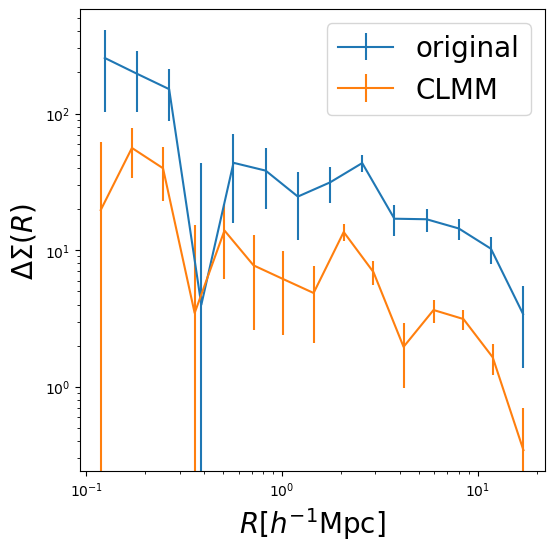

In [36]:
#Figure for the lensing signal
plt.figure(figsize=(6,6))
plt.errorbar(radial_bin,gt,yerr=gt_err,label='original')
plt.errorbar(
    cluster.profile["radius"],
    cluster.profile["DS_t"]/ 1e13,
    cluster.profile["DS_t_err"]/1e13,
    label='CLMM'
)
plt.loglog()
plt.legend(fontsize=20)
plt.xlabel(r'$R[h^{-1}{\rm Mpc}]$',fontsize=20)
plt.ylabel(r'$\Delta\Sigma(R)$',fontsize=20)
#plt.savefig('weaklens_hsc_clust.png')